In [4]:
%matplotlib inline
import glob
import os
import tables
import pandas as pd
import matplotlib.pylab as plt
from scipy.signal import medfilt
import numpy as np
import cv2

def add_reversal(feat_timeseries, th=-5):
#    med = feat_timeseries['midbody_speed'].median()
#    mad = (feat_timeseries['midbody_speed']-med).abs().median()
#    th = med - 3*mad

    feat_timeseries['is_reversal'] = 0
    for worm_index, tab in feat_timeseries.groupby('worm_index'):
        yy = tab['midbody_speed']
        #yy = tab['length']
        yy_med = medfilt(yy, 13)
        
        feat_timeseries.loc[tab.index, 'is_reversal'] = (yy_med<th)
    
    rev_frac = feat_timeseries.groupby('timestamp').agg({'is_reversal':np.mean})

    return rev_frac



/Users/ajaver/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


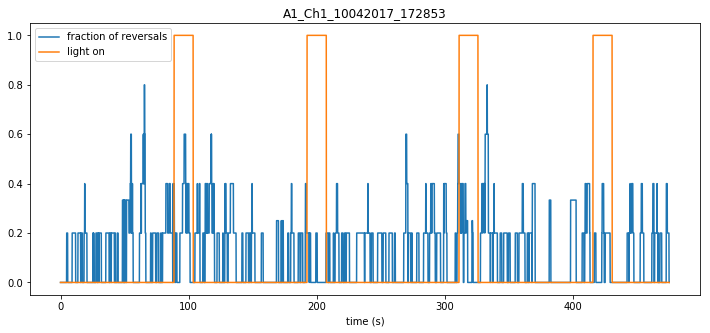

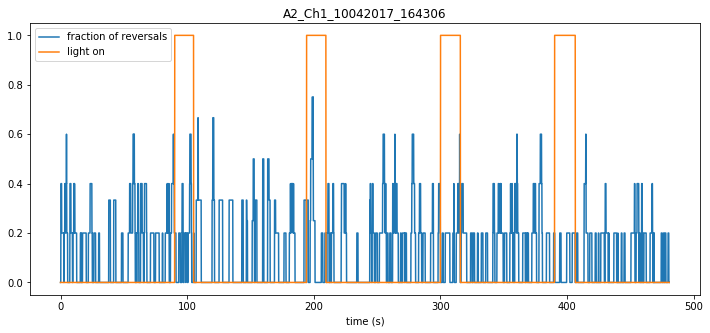

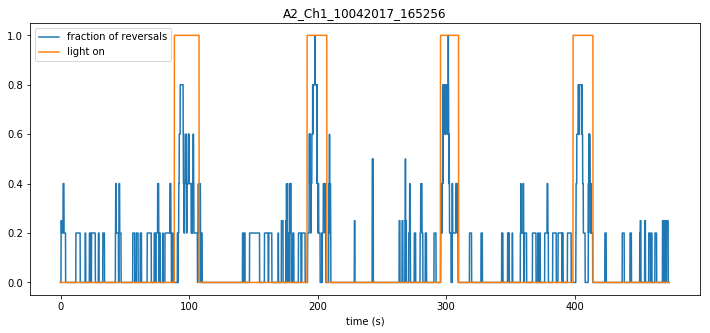

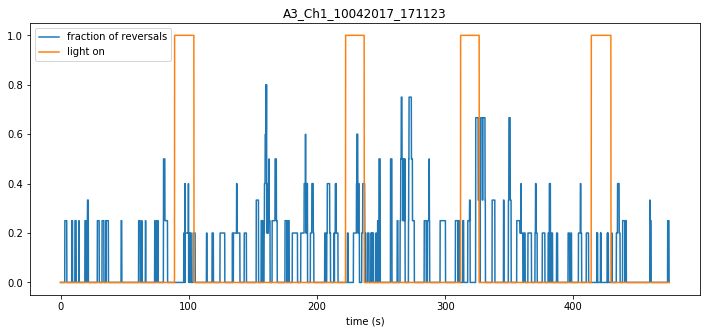

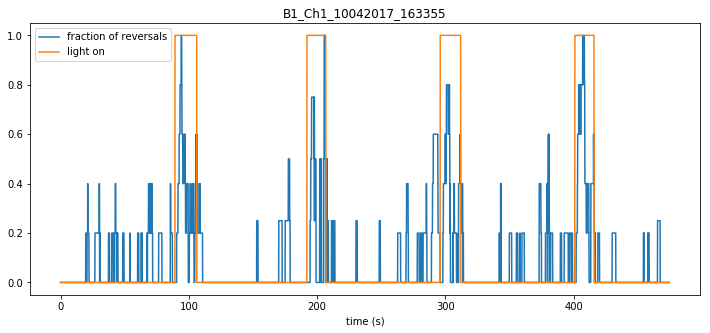

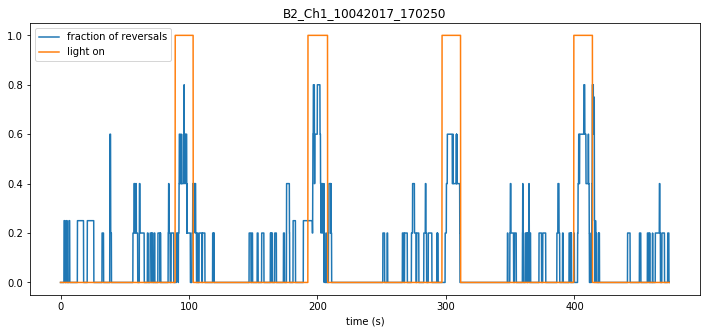

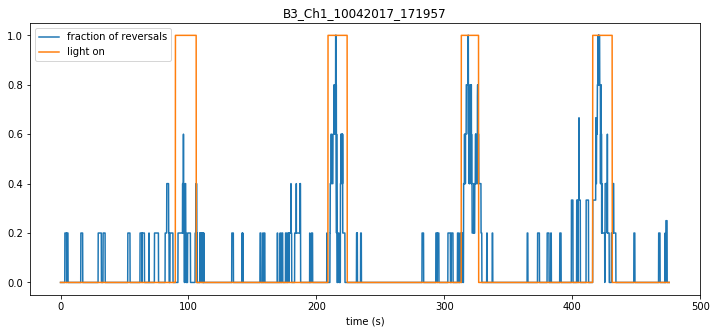

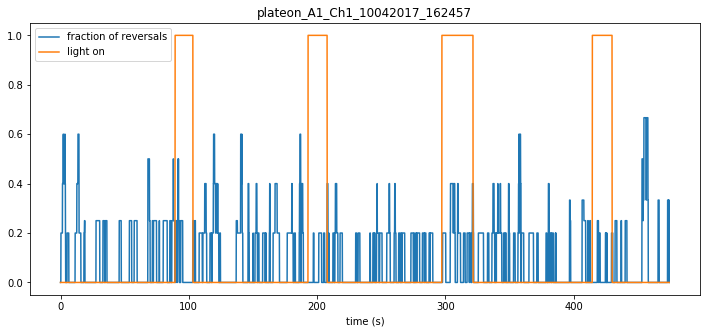

In [5]:
mask_dir = '/Users/ajaver/OneDrive - Imperial College London/tests/ATR_100417'
result_dir = mask_dir

feat_files = glob.glob(os.path.join(result_dir, '*_features.hdf5'))
mask_files = [x.replace('_features.hdf5', '.hdf5') for x in feat_files]

for mask_file, feat_file in zip(mask_files, feat_files):
    with tables.File(mask_file) as fid:
        mean_intensity = fid.get_node('/mean_intensity')[:]
    
    with pd.HDFStore(feat_file, 'r') as fid:
        feat_timeseries = fid['/features_timeseries']
    
    med = np.median(mean_intensity)
    mad = np.median(np.abs(mean_intensity-med))
    light_on = mean_intensity >  med + mad*6
    
    
    rev_frac = add_reversal(feat_timeseries, th=-5)
    #%%
    xx = np.arange(light_on.size)/25
    
    plt.figure(figsize=(12,5))
    d1, = plt.plot(xx, rev_frac, label='fraction of reversals')
    d2, = plt.plot(xx, light_on, label = 'light on')
    plt.legend(handles=[d1, d2], loc=2)
    #ax = sns.lmplot(x='timestamp', y='midbody_speed', hue='worm_index', 
    #                scatter=True, fit_reg=False, data=feat_timeseries)
    #plt.plot(-20*light_on)
    
    base_name = os.path.basename(mask_file).replace('.hdf5', '')
    plt.title(base_name)
    
    plt.xlabel('time (s)')